# Binary classification Model

### train / test split

In [65]:
import numpy as np
import torch
X_train = np.loadtxt("datasets/merged/X_train_imputed_scaled.csv", delimiter=",", skiprows=1)
X_test = np.loadtxt("datasets/merged/X_test_imputed_scaled.csv", delimiter=",", skiprows=1)
y_train = np.loadtxt("datasets/merged/y_train.csv", delimiter=",", skiprows=1)
y_test = np.loadtxt("datasets/merged/y_test.csv", delimiter=",", skiprows=1)

X_train = np.delete(X_train, 0, axis=1)
X_test = np.delete(X_test, 0, axis=1)
y_train = np.delete(y_train, 0, axis=1)
y_test = np.delete(y_test, 0, axis=1)

X_train = torch.from_numpy(X_train).type(torch.float32).squeeze()
X_test = torch.from_numpy(X_test).type(torch.float32).squeeze()
y_train = torch.from_numpy(y_train).type(torch.float32).squeeze()
y_test = torch.from_numpy(y_test).type(torch.float32).squeeze()


In [66]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([10018, 7]),
 torch.Size([2648, 7]),
 torch.Size([10018]),
 torch.Size([2648]))

In [67]:
type(X_train), X_train.dtype

(torch.Tensor, torch.float32)

In [68]:
type(y_train), y_train.dtype

(torch.Tensor, torch.float32)

In [69]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [70]:
torch.cuda.is_available()

False

### Construct Model Class

In [71]:
class ExoplanetsV0(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=int(hidden_units)),
            nn.ReLU(),
            #nn.Linear(in_features=int(hidden_units), out_features=int(hidden_units / 2)),
            #nn.ReLU(),
            nn.Linear(in_features=int(hidden_units), out_features=output_features),
            #nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)


# Create an instance of model
model_0 = ExoplanetsV0(input_features=X_test.shape[1], output_features=1, hidden_units=64).to(device)
model_0

ExoplanetsV0(
  (layers): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [72]:
X_train.shape, y_train.shape

(torch.Size([10018, 7]), torch.Size([10018]))

### Loss Function and Optimizer

In [73]:
# Create a loss function for binary classification
eps = 0.00001
### Tried to fix with wages-----------------------------------
weight_for_0 = len(y_test) + len(y_train) / (2 * ((y_test < eps).sum() + (y_train < eps).sum()))
weight_for_1 = len(y_test) + len(y_train) / (2 * ((y_test - 1 < eps).sum() + (y_train - 1 < eps).sum()))

pos_weight = torch.tensor([weight_for_1 / weight_for_0]).to(device)  # dla klasy 1
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
#loss_fn = nn.BCEWithLogitsLoss()
###----------------------------------------------------------

#loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer for binary classification
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

In [74]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

# Train Model

Model outputs are raw **Logits**

We are converting logits into prediction probabilities by passing them to some kind of activation function (int this case `nn.Sigmoid()`) Then we can convert our model's prediction probabilities to **prediction labels** by taking the `argmaX_scaled()`

In [75]:
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))
y_logits[:5]

tensor([[ 0.1067],
        [ 0.1409],
        [ 0.0391],
        [ 0.1189],
        [-0.0846]])

In [76]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5266],
        [0.5352],
        [0.5098],
        ...,
        [0.5282],
        [0.5089],
        [0.5238]])

In [77]:
torch.round(y_pred_probs)

tensor([[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]])

In [78]:
# find predicted labels
y_preds = torch.round(y_pred_probs)

# in full
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))))

# check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True,  ..., True, True, True])


tensor([1., 1., 1.,  ..., 1., 1., 1.])

In [79]:
y_test[:5]

tensor([1., 1., 0., 1., 1.])

### Building a training loop and testing loop

In [80]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 5000

# Tracking loss and accuracy
track_accuracy = []
track_loss = []
track_f1 = []
track_precision = []
track_recall = []
track_auc = []

track_test_f1 = []
track_test_precision = []
track_test_recall = []
track_test_auc = []
track_test_accuracy = []
track_test_loss = []


# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_probs = torch.sigmoid(y_logits)
    y_pred = torch.round(y_probs)  # turn logits into pred probs and into pred labels

    # 2. Calculate the loss / cost
    loss = loss_fn(y_logits, y_train)
    track_loss.append(loss.item())

    acc = accuracy_fn(y_true=y_train.detach(), y_pred=y_pred.detach())
    precision = precision_score(y_true=y_train.detach().cpu(), y_pred=y_pred.detach().cpu(), zero_division=0) * 100
    recall = recall_score(y_true=y_train.detach().cpu(), y_pred=y_pred.detach().cpu(), zero_division=0) * 100
    f1 = f1_score(y_true=y_train.detach().cpu(), y_pred=y_pred.detach().cpu(), zero_division=0) * 100
    auc = roc_auc_score(y_true=y_train.detach().cpu(), y_score=y_probs.detach().cpu())

    track_accuracy.append(acc)
    track_precision.append(precision)
    track_recall.append(recall)
    track_f1.append(f1)
    track_auc.append(auc)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Backpropagation algorithm
    loss.backward()

    # 5. Gradient descent algorithm
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()     # logits
        test_probs = torch.sigmoid(test_logits)     # Probability
        test_pred = torch.round(test_probs)         # 1 or 0

        # 2. Calculate test loss/acc

        test_loss = loss_fn(test_logits, y_test)
        track_test_loss.append(test_loss.item())

        test_acc = accuracy_fn(y_true=y_test.cpu(), y_pred=test_pred.cpu())
        test_precision = precision_score(y_true=y_test.cpu(), y_pred=test_pred.cpu(), zero_division=0) * 100
        test_recall = recall_score(y_true=y_test.cpu(), y_pred=test_pred.cpu(), zero_division=0) * 100
        test_f1 = f1_score(y_true=y_test.cpu(), y_pred=test_pred.cpu(), zero_division=0) * 100
        test_auc = roc_auc_score(y_true=y_test.cpu(), y_score=test_probs.cpu())
        track_test_auc.append(test_auc)

        track_test_accuracy.append(test_acc)
        track_test_precision.append(test_precision)
        track_test_recall.append(test_recall)
        track_test_f1.append(test_f1)

    # Print out what's happenin'
    if epoch % 500 == 0 or epoch == 9999:
        print(
            f"Epoch {epoch} \n"
            f" loss: {loss:.5f} | accuracy: {acc:.2f}% | Precision: {precision:.2f}% | Recall: {recall:.2f}% | f1: {f1:.2f}% | auc: {auc:.2f} \n"
            f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}% | Test precision: {test_precision:.2f}% | Test recall: {test_recall:.2f}% | Test f1: {test_f1:.2f}% | Test auc: {test_auc:.2f} \n")

Epoch 0 
 loss: 0.66910 | accuracy: 65.12% | Precision: 59.87% | Recall: 84.54% | f1: 70.10% | auc: 0.70 
Test loss: 0.66638 | Test accuracy: 67.98% | Test precision: 65.61% | Test recall: 82.77% | Test f1: 73.20% | Test auc: 0.72 

Epoch 500 
 loss: 0.60817 | accuracy: 68.36% | Precision: 65.11% | Recall: 74.49% | f1: 69.48% | auc: 0.74 
Test loss: 0.60441 | Test accuracy: 70.17% | Test precision: 71.73% | Test recall: 71.84% | Test f1: 71.79% | Test auc: 0.76 

Epoch 1000 
 loss: 0.58862 | accuracy: 69.33% | Precision: 65.11% | Recall: 78.80% | f1: 71.30% | auc: 0.75 
Test loss: 0.57942 | Test accuracy: 71.83% | Test precision: 71.72% | Test recall: 77.06% | Test f1: 74.29% | Test auc: 0.77 

Epoch 1500 
 loss: 0.57911 | accuracy: 70.24% | Precision: 65.60% | Recall: 80.89% | f1: 72.45% | auc: 0.76 
Test loss: 0.56734 | Test accuracy: 73.00% | Test precision: 72.35% | Test recall: 79.13% | Test f1: 75.59% | Test auc: 0.78 

Epoch 2000 
 loss: 0.57282 | accuracy: 70.71% | Precision: 6

# Tracking Accuracy

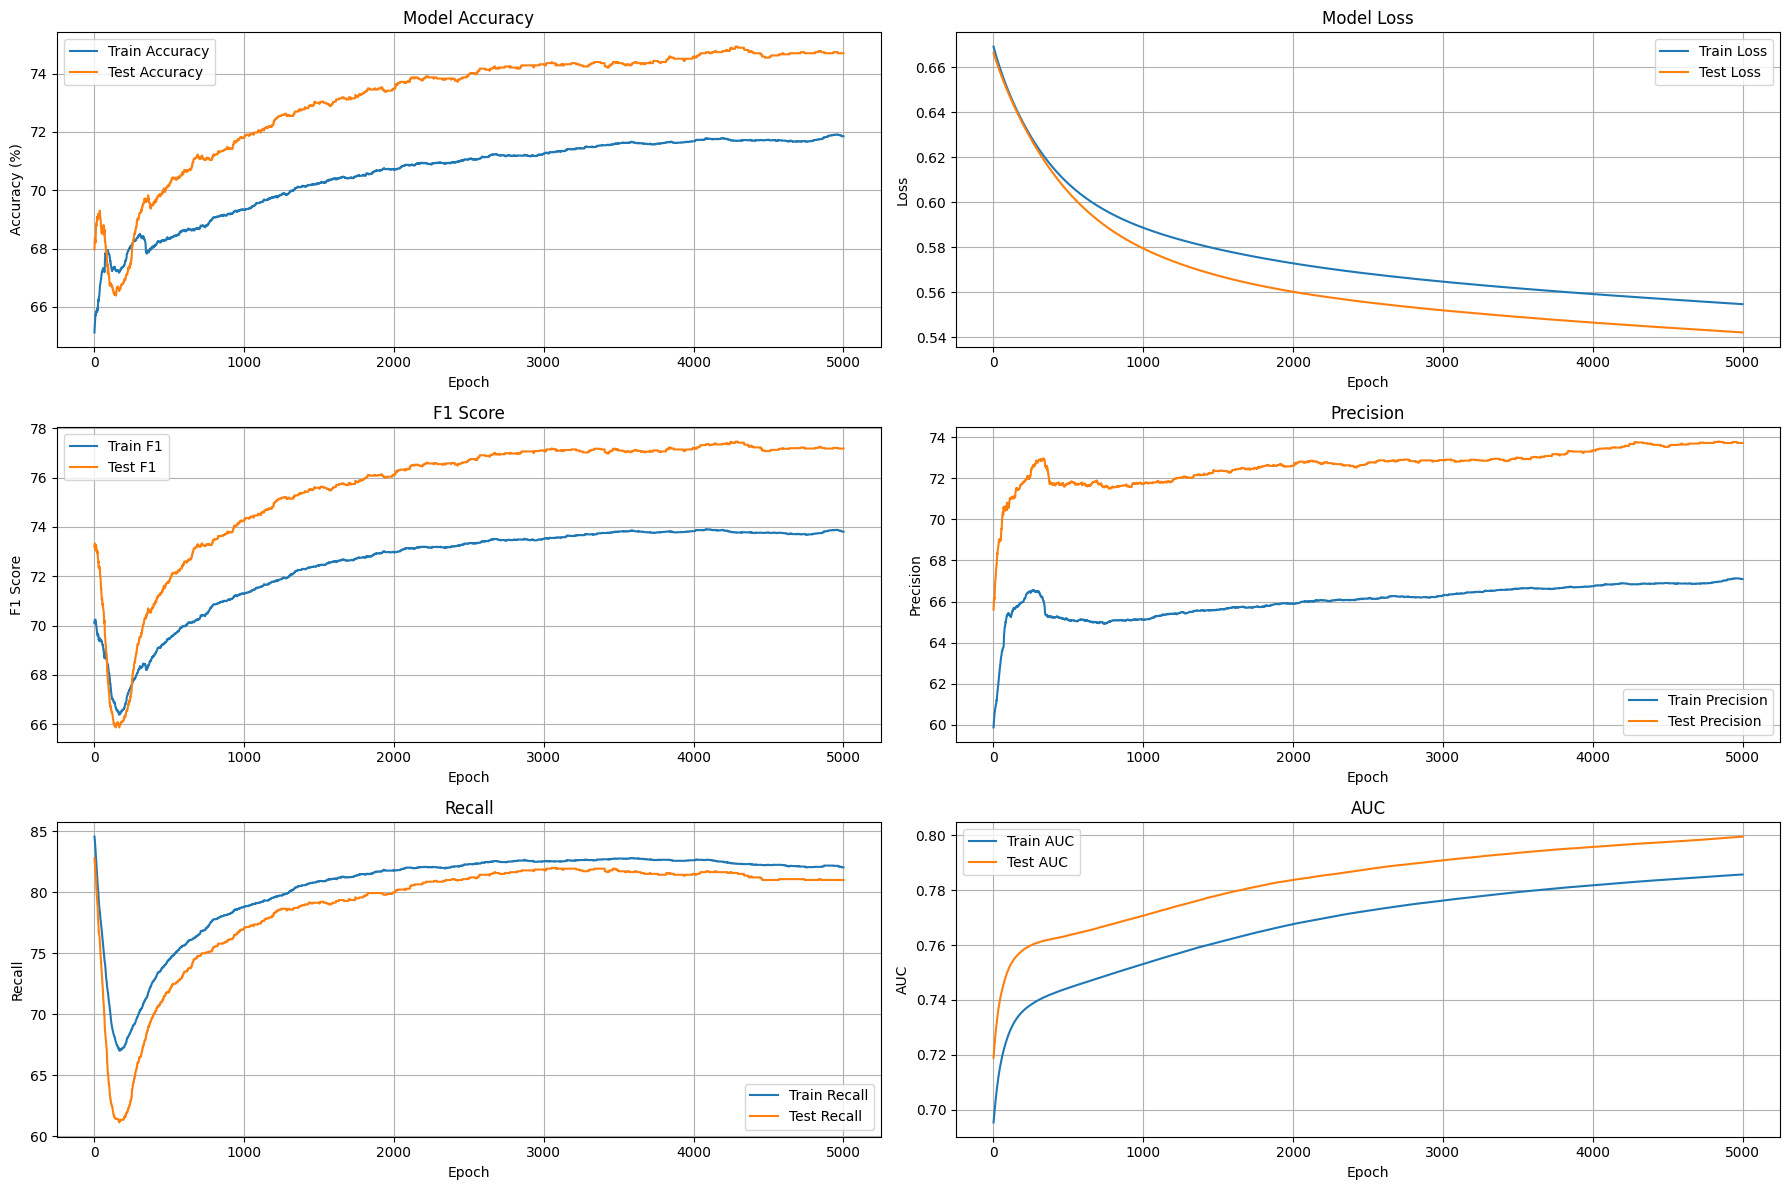

In [81]:
import matplotlib.pyplot as plt

epoch_range = range(1, epochs + 1)

plt.figure(figsize=(18, 12))

# Accuracy
plt.subplot(3, 2, 1)
plt.plot(epoch_range, track_accuracy, label='Train Accuracy')
plt.plot(epoch_range, track_test_accuracy, label='Test Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(3, 2, 2)
plt.plot(epoch_range, track_loss, label='Train Loss')
plt.plot(epoch_range, track_test_loss, label='Test Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# F1 Score
plt.subplot(3, 2, 3)
plt.plot(epoch_range, track_f1, label='Train F1')
plt.plot(epoch_range, track_test_f1, label='Test F1')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

# Precision
plt.subplot(3, 2, 4)
plt.plot(epoch_range, track_precision, label='Train Precision')
plt.plot(epoch_range, track_test_precision, label='Test Precision')
plt.title('Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

# Recall
plt.subplot(3, 2, 5)
plt.plot(epoch_range, track_recall, label='Train Recall')
plt.plot(epoch_range, track_test_recall, label='Test Recall')
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

# AUC
plt.subplot(3, 2, 6)
plt.plot(epoch_range, track_auc, label='Train AUC')
plt.plot(epoch_range, track_test_auc, label='Test AUC')
plt.title('AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_metrics.png', dpi=300)  # Zapisuje wykres w wysokiej jakości
plt.show()


# Saving and loading already trained Model

Creating template / method for effective saving already trained model, so user don't have to wait for it to finish training before usage.

In [82]:
# Saving our PyTorch model
from pathlib import Path

# 1. Create models directory if it doesn't exist yet
MODEL_PATH = Path("saved_models")
MODEL_PATH.mkdir(parents = True, exist_ok = True)

# 2. Create model save path
MODEL_NAME = "nn_exoplanets0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj = model_0.state_dict(),
           f = MODEL_SAVE_PATH)

Saving model to: saved_models/nn_exoplanets0.pth


In [83]:
!ls -l saved_models

total 24
-rw-rw-r-- 1 maciekb maciekb 22121 Oct  4 21:35 nn_exoplanets0.pth


### Loading Trained model



In [84]:
# To load in a saved state_dict we have to instantiate a new instace of our model class
loaded_model_0 = ExoplanetsV0(input_features = 7, output_features = 1, hidden_units = 64)

#Load the saved state_dict of model_0 (update the new instance with old parameters
loaded_model_0.load_state_dict(torch.load(f = MODEL_SAVE_PATH))

<All keys matched successfully>

In [85]:
loaded_model_0.eval()
with torch.inference_mode():
    loaded_logits = loaded_model_0(X_test.to(device))
    loaded_pred_probs = torch.sigmoid(loaded_logits)
    loaded_preds = torch.round(loaded_pred_probs)

loaded_preds

tensor([[1.],
        [1.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]])

In [86]:
loaded_preds == y_preds

tensor([[ True],
        [ True],
        [False],
        ...,
        [ True],
        [ True],
        [ True]])

In [87]:
loaded_preds, y_preds

(tensor([[1.],
         [1.],
         [0.],
         ...,
         [1.],
         [1.],
         [1.]]),
 tensor([[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]]))

# Using already trained model to evaluate new input data

In [88]:
loaded_model_0.eval()

ExoplanetsV0(
  (layers): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [93]:
### Tu znajduje sie jakieś wczytywanie inputu użytkownika
input = np.loadtxt("datasets/merged/X_test_imputed_scaled.csv", delimiter=",", skiprows=1) # X_test from merged dataset
input = np.delete(input, 0, axis=1)

input= torch.from_numpy(input).type(torch.float32).squeeze()

In [94]:
import pandas as pd
with torch.no_grad():
    logits = loaded_model_0(input)
    probabilities = torch.sigmoid(logits).squeeze()   # wartości 0–1
    predictions = (probabilities > 0.5).int()         # 1 = planeta, 0 = nie

# ======================
# Zapis wyników do CSV
# ======================
results = pd.DataFrame({
    "probability": probabilities.cpu().numpy(),
    "prediction": predictions.cpu().numpy()
})

output_path = "predictions.csv"
results.to_csv(output_path, index=False)

print(f"✅ Zapisano wyniki do pliku: {output_path}")
print(results.head())


✅ Zapisano wyniki do pliku: predictions.csv
   probability  prediction
0     0.702534           1
1     0.663533           1
2     0.375448           0
3     0.765297           1
4     0.413082           0


# Looking for mistakes

### Balance between classes

#### Fix 1. Using wage in loss_fn

Using wage in BCEWithLogitsLoss()

#### Fix 2. Using fake data to check if model is learning anything

In [58]:
import numpy as np
import torch
from sklearn.datasets import make_classification

# Stwórz sztuczne dane które NA PEWNO są przewidywalne
X_easy, y_easy = make_classification(
    n_samples=2000,
    n_features=10,
    n_informative=8,  # 8 użytecznych features
    n_redundant=2,  # 2 zbędne features
    n_clusters_per_class=1,
    random_state=42
)

# Konwersja do tensorów
X_easy_tensor = torch.from_numpy(X_easy).float()
y_easy_tensor = torch.from_numpy(y_easy).float()

print(f"Easy data - X: {X_easy_tensor.shape}, y: {y_easy_tensor.shape}")
print(f"Class balance: {y_easy.mean():.3f} positive")

Easy data - X: torch.Size([2000, 10]), y: torch.Size([2000])
Class balance: 0.497 positive


In [ ]:
# Test on easy data
def test_your_model():
    # Generate easy data (18 features like in  original data)
    X_easy, y_easy = make_classification(
        n_samples=2000,
        n_features=18,  # SAME AS IN DATA
        n_informative=16,  # Most features are useful
        n_redundant=2,
        n_clusters_per_class=1,
        random_state=42,
        flip_y=0.01  # Only 1% noise
    )

    # Convert to tensors -
    X_easy_tensor = torch.from_numpy(X_easy).float()
    y_easy_tensor = torch.from_numpy(y_easy).float()

    # Train/test split
    split_idx = int(0.8 * len(X_easy_tensor))
    X_train = X_easy_tensor[:split_idx]
    X_test = X_easy_tensor[split_idx:]
    y_train = y_easy_tensor[:split_idx]
    y_test = y_easy_tensor[split_idx:]

    # USE EXACT MODEL
    model = ExoplanetsV0(input_features=18, output_features=1, hidden_units=128)

    # USED HYPERPARAMETERS (you can also test different ones)
    optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)  # optimizer
    loss_fn = nn.BCEWithLogitsLoss()  # loss function

    print("=== TESTING YOUR MODEL ON EASY DATA ===")
    print(f"Model: {model}")
    print(f"Optimizer: SGD lr=0.01")
    print(f"Data: {X_train.shape} -> {y_train.shape}")

    # Training
    for epoch in range(100):
        model.train()
        optimizer.zero_grad()

        # Forward pass
        y_logits = model(X_train).squeeze()

        # prediction logic
        y_pred = torch.round(torch.sigmoid(y_logits))

        # Loss
        loss = loss_fn(y_logits, y_train)  # BCEWithLogitsLoss with logits
        acc = (y_pred == y_train).float().mean()

        # Backward
        loss.backward()
        optimizer.step()

        # Test every 20 epochs
        if epoch % 20 == 0:
            model.eval()
            with torch.no_grad():
                test_logits = model(X_test).squeeze()
                test_pred = torch.round(torch.sigmoid(test_logits))
                test_loss = loss_fn(test_logits, y_test)
                test_acc = (test_pred == y_test).float().mean()

            print(
                f"Epoch {epoch:3d} | Train Loss: {loss:.4f}, Acc: {acc:.4f} | Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}")

    final_test_acc = (test_pred == y_test).float().mean()
    print(f"\n FINAL TEST ACCURACY: {final_test_acc:.4f}")

    if final_test_acc > 0.85:
        print("MODEL WORKS CORRECTLY - problem is in KEPLER DATA")
        return True
    elif final_test_acc > 0.6:
        print("MODEL WORKS POORLY - possible architecture problem")
        return False
    else:
        print("MODEL DOESN'T WORK - problem in IMPLEMENTATION")
        return False


# Run test
print("Testing YOUR exact model on easy data...")
model_works = test_your_model()

### Conclusion

Problem in `Sigmoid()` in `nn.Sequential`. Sigmoid should be used to round when we want to convert logits > probs > labels, it was affecting final answer when used in wrong place.

Model can achieve ~60% accuracy on Dataset, let's try wages now, with working implementation. -> Model achieves over 90% accuracy.

### Observations

* When applied change and increased number of hidden layers
    * `Linear>ReLU>Linear>ReLU>Linear>` -> `Linear>ReLU>Linear>ReLU>Linear>ReLU>Linear` accuracy dropped to 60,5% and model wasn't learning